In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numpy.random as nprd
import numpy.linalg as npla
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import bootstrap_plot
import statsmodels.api as sm
from feature_selection import FeatureSelection as fs

## Get rid of useless data and change string into computable datatype

In [2]:
data = pd.read_csv("companies_years_2009_2020_p4_v1_total.csv")
data_new = data.drop(columns = ['exchange', 'href', 'company_address', 'phone', 'company_name','Unnamed: 0', 'ticker'])
tag = data_new.columns
data_new['date_of_priced'] = pd.to_datetime(data_new['date_of_priced'])
change_tag = ['dollar_value_of_shares','shares_offered', 'shares_outstanding','1','2','3','4','5']
for idx in change_tag:
    data_new.update(data_new[idx].str.replace(r'\$', ''))
    data_new.update(data_new[idx].str.replace(r'\,', '').astype(float))
data_new[['shares_offered','dollar_value_of_shares','shares_outstanding']] = data_new[['shares_offered','dollar_value_of_shares','shares_outstanding']].astype(float)

<ipython-input-2-6b044e80b2bd>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  data_new.update(data_new[idx].str.replace(r'\$', ''))
<ipython-input-2-6b044e80b2bd>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data_new.update(data_new[idx].str.replace(r'\,', '').astype(float))


## Replace all 0 in week 1,2,3,4,5 with null

In [3]:
data_new[['1','2','3','4','5']] = data_new[['1','2','3','4','5']].replace(0 ,np.nan)
data_new['date_of_priced'] = pd.to_datetime(data_new['date_of_priced'])
data_new.isnull().sum()

share_price                0
shares_offered             0
dollar_value_of_shares     0
date_of_priced             0
employees                  0
shares_outstanding         0
stock_valuation            0
sicdescription             0
ebit                       0
grossprofit                0
netincome                  0
totalrevenue               0
costofrevenue              0
totalassets                0
revenue_growth             0
1                         44
2                         44
3                         44
4                         44
5                         44
dtype: int64

## Delete all null data

In [4]:
data_nonzero = data_new[~(data_new['1'].isnull()) ]
data_nonzero.to_csv("ClearedData_deleteNulls.csv",index = False)
data_nonzero

,share_price,shares_offered,dollar_value_of_shares,date_of_priced,employees,shares_outstanding,stock_valuation,sicdescription,ebit,grossprofit,netincome,totalrevenue,costofrevenue,totalassets,revenue_growth,1,2,3,4,5
0,10.5,13500000.0,1.417500e+08,2009-04-15,2971,53139723.0,5.579671e+08,Services-Educational Services,33420000.0,155468000.0,26431000.0,2.182900e+08,6.282200e+07,1.292460e+08,1.546874,11.10,12.05,12.010,11.65,11.00
1,6.0,1700000.0,1.020000e+07,2009-07-30,96,3951811.0,2.371087e+07,"Oil and Gas Field Services, Not Elsewhere Clas...",2436607.0,3789779.0,1691949.0,9.592261e+06,5.802482e+06,8.933083e+06,0.262541,27.85,29.75,32.350,37.05,45.70
2,17.0,5000000.0,8.500000e+07,2009-08-11,59,17091191.0,2.905502e+08,Pharmaceutical Preparations,7282221.0,32029488.0,4766249.0,3.507516e+07,3.045672e+06,3.111919e+07,0.249846,16.83,17.00,17.045,17.01,16.80
3,10.0,30000000.0,3.000000e+08,2009-09-25,21700,156092873.0,1.560929e+09,Services-Hospitals,196408000.0,361521000.0,22441000.0,2.153362e+09,1.791841e+09,2.562425e+09,0.081186,10.09,10.45,10.090,10.07,10.00
4,14.0,5700000.0,7.980000e+07,2009-10-02,553,21493655.0,3.009112e+08,Arrangement of Transportation of Freight and C...,4945195.0,43090276.0,2875556.0,2.028076e+08,1.597174e+08,4.590902e+07,1.124508,14.06,14.00,14.000,13.51,12.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,10.5,58750000.0,6.168750e+08,2020-11-19,3355,58750000.0,6.168750e+08,"Perfumes, Cosmetics and Other Toilet Preparations",20638000.0,276736000.0,10055000.0,4.351560e+08,1.584200e+08,2.886020e+08,3.702610,18.40,20.03,18.240,17.15,16.86
446,27.0,60000000.0,1.620000e+09,2020-11-20,390,88965664.0,2.402073e+09,Pharmaceutical Preparations,23988000.0,76291000.0,-4470000.0,1.431400e+08,6.684900e+07,5.777960e+08,0.155912,29.85,29.00,26.290,26.96,29.16
447,23.0,46600000.0,1.071800e+09,2020-11-20,2900,277431755.0,6.380930e+09,Services-Miscellaneous Health and Allied Servi...,183597000.0,395431000.0,-20850000.0,7.783270e+08,3.828960e+08,2.580674e+09,0.043125,25.10,27.95,27.000,26.76,27.97
448,10.0,2400000.0,2.400000e+07,2020-11-24,14,7577677.0,7.577677e+07,Ship And Boat Building And Repairing,333700.0,1285364.0,233066.0,2.869377e+06,1.584013e+06,1.914562e+06,1.256569,14.44,14.21,14.120,13.15,12.79


In [5]:
data_cal = data_nonzero.drop(columns = ['date_of_priced', 'sicdescription'])
target = data_nonzero[['1','2','3','4','5']]
tag = ['1','2','3','4','5']

print("Features selected by forward selection for week 1:", fs.forward_selection(data_cal.drop(columns = tag), target['1'], 0.05))
print("Features selected by forward selection for week 2:", fs.forward_selection(data_cal.drop(columns = tag[1:]), target['2'], 0.05))
print("Features selected by forward selection for week 3:", fs.forward_selection(data_cal.drop(columns = tag[2:]), target['3'], 0.05))
print("Features selected by forward selection for week 4:", fs.forward_selection(data_cal.drop(columns = tag[3:]), target['4'], 0.05))
print("Features selected by forward selection for week 5:", fs.forward_selection(data_cal.drop(columns = tag[4:]), target['5'], 0.05))
print("\n")
print("Features selected by forward selection for week 1:", fs.forward_selection(data_cal.drop(columns = tag), target['1'], 0.05))
print("Features selected by forward selection for week 2:", fs.forward_selection(data_cal.drop(columns = tag), target['2'], 0.05))
print("Features selected by forward selection for week 3:", fs.forward_selection(data_cal.drop(columns = tag), target['3'], 0.05))
print("Features selected by forward selection for week 4:", fs.forward_selection(data_cal.drop(columns = tag), target['4'], 0.05))
print("Features selected by forward selection for week 5:", fs.forward_selection(data_cal.drop(columns = tag), target['5'], 0.05))
print("\n")
print("Features selected by backward elimination for week 1:", fs.backward_elimination(data_cal.drop(columns = tag), target['1'], 0.05)[0])
print("Features selected by backward elimination for week 2:", fs.backward_elimination(data_cal.drop(columns = tag[1:]), target['2'], 0.05)[0])
print("Features selected by backward elimination for week 3:", fs.backward_elimination(data_cal.drop(columns = tag[2:]), target['3'], 0.05)[0])
print("Features selected by backward elimination for week 4:", fs.backward_elimination(data_cal.drop(columns = tag[3:]), target['4'], 0.05)[0])
print("Features selected by backward elimination for week 5:", fs.backward_elimination(data_cal.drop(columns = tag[4:]), target['5'], 0.05)[0])
print("\n")
print("Features selected by backward elimination for week 1:", fs.backward_elimination(data_cal.drop(columns = tag), target['1'], 0.05)[0])
print("Features selected by backward elimination for week 2:", fs.backward_elimination(data_cal.drop(columns = tag), target['2'], 0.05)[0])
print("Features selected by backward elimination for week 3:", fs.backward_elimination(data_cal.drop(columns = tag), target['3'], 0.05)[0])
print("Features selected by backward elimination for week 4:", fs.backward_elimination(data_cal.drop(columns = tag), target['4'], 0.05)[0])
print("Features selected by backward elimination for week 5:", fs.backward_elimination(data_cal.drop(columns = tag), target['5'], 0.05)[0])


Features selected by forward selection for week 1: ['share_price']
Features selected by forward selection for week 2: ['1']
Features selected by forward selection for week 3: ['2', '1', 'share_price', 'dollar_value_of_shares']
Features selected by forward selection for week 4: ['1', '3', '2']
Features selected by forward selection for week 5: ['1', '4', '2', '3']


Features selected by forward selection for week 1: ['share_price']
Features selected by forward selection for week 2: []
Features selected by forward selection for week 3: ['share_price']
Features selected by forward selection for week 4: ['share_price']
Features selected by forward selection for week 5: ['share_price']


Features selected by backward elimination for week 1: ['share_price']
Features selected by backward elimination for week 2: ['1' 'netincome' 'dollar_value_of_shares' 'shares_outstanding'
 'shares_offered' 'share_price' 'totalassets' 'costofrevenue'
 'stock_valuation' 'employees' 'totalrevenue' 'ebit']
Featu

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     2.870
Date:                Tue, 27 Apr 2021   Prob (F-statistic):           0.000567
Time:                        20:11:40   Log-Likelihood:                -1348.5
No. Observations:                 406   AIC:                             2725.
Df Residuals:                     392   BIC:                             2781.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

Text(0, 0.5, '(day5 - share_price)/share_price')

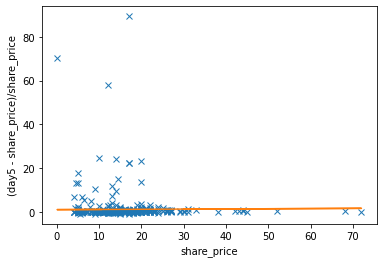

In [6]:
X = data_cal.drop(columns = ['1','2','3','4','5'])
X = sm.add_constant(X)
y = (data_cal['5'] - data_cal['share_price'])/ data_cal['share_price']
model = sm.OLS(y,X)
result = model.fit();
print(result.summary())
plt.plot(data_cal['share_price'],y,'x', label = 'data' )
a = result.params['share_price']
b = result.params['const']
plt.plot(data_cal['share_price'], data_cal['share_price'] * a + b, label = 'prox' )
plt.xlabel("share_price")
plt.ylabel("(day5 - share_price)/share_price")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.3125
Date:                Tue, 27 Apr 2021   Prob (F-statistic):              0.990
Time:                        20:11:40   Log-Likelihood:                -2419.4
No. Observations:                 406   AIC:                             4867.
Df Residuals:                     392   BIC:                             4923.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     13

Text(0, 0.5, 'day5 - share_price')

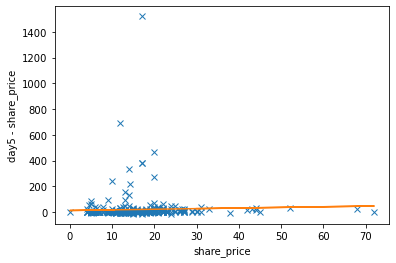

In [7]:
X = data_cal.drop(columns = ['1','2','3','4','5'])
X = sm.add_constant(X)
y = (data_cal['5'] - data_cal['share_price'])
model = sm.OLS(y,X)
result = model.fit();
print(result.summary())
plt.plot(data_cal['share_price'],y,'x', label = 'data' )
a = result.params['share_price']
b = result.params['const']
plt.plot(data_cal['share_price'], data_cal['share_price'] * a + b, label = 'prox' )
plt.xlabel("share_price")
plt.ylabel("day5 - share_price")

In [8]:
#DBSCAN work
data_nonzero





,share_price,shares_offered,dollar_value_of_shares,date_of_priced,employees,shares_outstanding,stock_valuation,sicdescription,ebit,grossprofit,netincome,totalrevenue,costofrevenue,totalassets,revenue_growth,1,2,3,4,5
0,10.5,13500000.0,1.417500e+08,2009-04-15,2971,53139723.0,5.579671e+08,Services-Educational Services,33420000.0,155468000.0,26431000.0,2.182900e+08,6.282200e+07,1.292460e+08,1.546874,11.10,12.05,12.010,11.65,11.00
1,6.0,1700000.0,1.020000e+07,2009-07-30,96,3951811.0,2.371087e+07,"Oil and Gas Field Services, Not Elsewhere Clas...",2436607.0,3789779.0,1691949.0,9.592261e+06,5.802482e+06,8.933083e+06,0.262541,27.85,29.75,32.350,37.05,45.70
2,17.0,5000000.0,8.500000e+07,2009-08-11,59,17091191.0,2.905502e+08,Pharmaceutical Preparations,7282221.0,32029488.0,4766249.0,3.507516e+07,3.045672e+06,3.111919e+07,0.249846,16.83,17.00,17.045,17.01,16.80
3,10.0,30000000.0,3.000000e+08,2009-09-25,21700,156092873.0,1.560929e+09,Services-Hospitals,196408000.0,361521000.0,22441000.0,2.153362e+09,1.791841e+09,2.562425e+09,0.081186,10.09,10.45,10.090,10.07,10.00
4,14.0,5700000.0,7.980000e+07,2009-10-02,553,21493655.0,3.009112e+08,Arrangement of Transportation of Freight and C...,4945195.0,43090276.0,2875556.0,2.028076e+08,1.597174e+08,4.590902e+07,1.124508,14.06,14.00,14.000,13.51,12.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,10.5,58750000.0,6.168750e+08,2020-11-19,3355,58750000.0,6.168750e+08,"Perfumes, Cosmetics and Other Toilet Preparations",20638000.0,276736000.0,10055000.0,4.351560e+08,1.584200e+08,2.886020e+08,3.702610,18.40,20.03,18.240,17.15,16.86
446,27.0,60000000.0,1.620000e+09,2020-11-20,390,88965664.0,2.402073e+09,Pharmaceutical Preparations,23988000.0,76291000.0,-4470000.0,1.431400e+08,6.684900e+07,5.777960e+08,0.155912,29.85,29.00,26.290,26.96,29.16
447,23.0,46600000.0,1.071800e+09,2020-11-20,2900,277431755.0,6.380930e+09,Services-Miscellaneous Health and Allied Servi...,183597000.0,395431000.0,-20850000.0,7.783270e+08,3.828960e+08,2.580674e+09,0.043125,25.10,27.95,27.000,26.76,27.97
448,10.0,2400000.0,2.400000e+07,2020-11-24,14,7577677.0,7.577677e+07,Ship And Boat Building And Repairing,333700.0,1285364.0,233066.0,2.869377e+06,1.584013e+06,1.914562e+06,1.256569,14.44,14.21,14.120,13.15,12.79


In [9]:

day_prices = data_nonzero[['1','2','3','4','5']]
print(day_prices)
#day_prices = day_prices.drop('percent_change_after_day_1')
print(day_prices)

         1      2       3      4      5
0    11.10  12.05  12.010  11.65  11.00
1    27.85  29.75  32.350  37.05  45.70
2    16.83  17.00  17.045  17.01  16.80
3    10.09  10.45  10.090  10.07  10.00
4    14.06  14.00  14.000  13.51  12.98
..     ...    ...     ...    ...    ...
445  18.40  20.03  18.240  17.15  16.86
446  29.85  29.00  26.290  26.96  29.16
447  25.10  27.95  27.000  26.76  27.97
448  14.44  14.21  14.120  13.15  12.79
449  40.18  39.01  40.000  40.02  40.19

[406 rows x 5 columns]
         1      2       3      4      5
0    11.10  12.05  12.010  11.65  11.00
1    27.85  29.75  32.350  37.05  45.70
2    16.83  17.00  17.045  17.01  16.80
3    10.09  10.45  10.090  10.07  10.00
4    14.06  14.00  14.000  13.51  12.98
..     ...    ...     ...    ...    ...
445  18.40  20.03  18.240  17.15  16.86
446  29.85  29.00  26.290  26.96  29.16
447  25.10  27.95  27.000  26.76  27.97
448  14.44  14.21  14.120  13.15  12.79
449  40.18  39.01  40.000  40.02  40.19

[406 rows x 5 c

In [10]:
#convert to 
df = day_prices
df["1"] = pd.to_numeric(df["1"]).copy()
df["2"] = pd.to_numeric(df["2"]).copy()
df["3"] = pd.to_numeric(df["3"]).copy()
df["4"] = pd.to_numeric(df["4"]).copy()
df["5"] = pd.to_numeric(df["5"]).copy()
print(df)


         1      2       3      4      5
0    11.10  12.05  12.010  11.65  11.00
1    27.85  29.75  32.350  37.05  45.70
2    16.83  17.00  17.045  17.01  16.80
3    10.09  10.45  10.090  10.07  10.00
4    14.06  14.00  14.000  13.51  12.98
..     ...    ...     ...    ...    ...
445  18.40  20.03  18.240  17.15  16.86
446  29.85  29.00  26.290  26.96  29.16
447  25.10  27.95  27.000  26.76  27.97
448  14.44  14.21  14.120  13.15  12.79
449  40.18  39.01  40.000  40.02  40.19

[406 rows x 5 columns]


<ipython-input-10-0d6a9d20f874>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["1"] = pd.to_numeric(df["1"]).copy()
<ipython-input-10-0d6a9d20f874>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["2"] = pd.to_numeric(df["2"]).copy()
<ipython-input-10-0d6a9d20f874>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [11]:
#subtract = 
df_1 = df
changes_day_1 = (df["2"]-df["1"]) / df["1"] * 100
changes_day_2 = (df["3"]-df["2"]) / df["2"] * 100
changes_day_3 = (df["4"]-df["3"]) / df["3"] * 100
changes_day_4 = (df["5"]-df["4"]) / df["4"] * 100
print(changes_day_1)

0       8.558559
1       6.822262
2       1.010101
3       3.567889
4      -0.426743
         ...    
445     8.858696
446    -2.847571
447    11.354582
448    -1.592798
449    -2.911896
Length: 406, dtype: float64


In [12]:
#assign dataframe
df_1 = df_1.assign(a=changes_day_1.values)
print(df_1)
df = df.assign(day_1_change = changes_day_1.values)
df = df.assign(day_2_change = changes_day_2.values)
df = df.assign(day_3_change = changes_day_3.values)
df = df.assign(day_4_change = changes_day_4.values)

print(df)

         1      2       3      4      5          a
0    11.10  12.05  12.010  11.65  11.00   8.558559
1    27.85  29.75  32.350  37.05  45.70   6.822262
2    16.83  17.00  17.045  17.01  16.80   1.010101
3    10.09  10.45  10.090  10.07  10.00   3.567889
4    14.06  14.00  14.000  13.51  12.98  -0.426743
..     ...    ...     ...    ...    ...        ...
445  18.40  20.03  18.240  17.15  16.86   8.858696
446  29.85  29.00  26.290  26.96  29.16  -2.847571
447  25.10  27.95  27.000  26.76  27.97  11.354582
448  14.44  14.21  14.120  13.15  12.79  -1.592798
449  40.18  39.01  40.000  40.02  40.19  -2.911896

[406 rows x 6 columns]
         1      2       3      4      5  day_1_change  day_2_change  \
0    11.10  12.05  12.010  11.65  11.00      8.558559     -0.331950   
1    27.85  29.75  32.350  37.05  45.70      6.822262      8.739496   
2    16.83  17.00  17.045  17.01  16.80      1.010101      0.264706   
3    10.09  10.45  10.090  10.07  10.00      3.567889     -3.444976   
4    14.0

In [78]:
A = data_nonzero.drop(columns = ['1','2','3','4','5', 'date_of_priced'])
#A = A.drop('percent_change_after_day_1')
A = A.assign(day_1_change = changes_day_1.values)
A = A.assign(day_2_change = changes_day_2.values)
A = A.assign(day_3_change = changes_day_3.values)
A = A.assign(day_4_change = changes_day_4.values)
A




,share_price,shares_offered,dollar_value_of_shares,employees,shares_outstanding,stock_valuation,sicdescription,ebit,grossprofit,netincome,totalrevenue,costofrevenue,totalassets,revenue_growth,day_1_change,day_2_change,day_3_change,day_4_change
0,10.5,13500000.0,1.417500e+08,2971,53139723.0,5.579671e+08,Services-Educational Services,33420000.0,155468000.0,26431000.0,2.182900e+08,6.282200e+07,1.292460e+08,1.546874,8.558559,-0.331950,-2.997502,-5.579399
1,6.0,1700000.0,1.020000e+07,96,3951811.0,2.371087e+07,"Oil and Gas Field Services, Not Elsewhere Clas...",2436607.0,3789779.0,1691949.0,9.592261e+06,5.802482e+06,8.933083e+06,0.262541,6.822262,8.739496,14.528594,23.346829
2,17.0,5000000.0,8.500000e+07,59,17091191.0,2.905502e+08,Pharmaceutical Preparations,7282221.0,32029488.0,4766249.0,3.507516e+07,3.045672e+06,3.111919e+07,0.249846,1.010101,0.264706,-0.205339,-1.234568
3,10.0,30000000.0,3.000000e+08,21700,156092873.0,1.560929e+09,Services-Hospitals,196408000.0,361521000.0,22441000.0,2.153362e+09,1.791841e+09,2.562425e+09,0.081186,3.567889,-3.444976,-0.198216,-0.695134
4,14.0,5700000.0,7.980000e+07,553,21493655.0,3.009112e+08,Arrangement of Transportation of Freight and C...,4945195.0,43090276.0,2875556.0,2.028076e+08,1.597174e+08,4.590902e+07,1.124508,-0.426743,0.000000,-3.500000,-3.923020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,10.5,58750000.0,6.168750e+08,3355,58750000.0,6.168750e+08,"Perfumes, Cosmetics and Other Toilet Preparations",20638000.0,276736000.0,10055000.0,4.351560e+08,1.584200e+08,2.886020e+08,3.702610,8.858696,-8.936595,-5.975877,-1.690962
446,27.0,60000000.0,1.620000e+09,390,88965664.0,2.402073e+09,Pharmaceutical Preparations,23988000.0,76291000.0,-4470000.0,1.431400e+08,6.684900e+07,5.777960e+08,0.155912,-2.847571,-9.344828,2.548498,8.160237
447,23.0,46600000.0,1.071800e+09,2900,277431755.0,6.380930e+09,Services-Miscellaneous Health and Allied Servi...,183597000.0,395431000.0,-20850000.0,7.783270e+08,3.828960e+08,2.580674e+09,0.043125,11.354582,-3.398927,-0.888889,4.521674
448,10.0,2400000.0,2.400000e+07,14,7577677.0,7.577677e+07,Ship And Boat Building And Repairing,333700.0,1285364.0,233066.0,2.869377e+06,1.584013e+06,1.914562e+06,1.256569,-1.592798,-0.633357,-6.869688,-2.737643


In [79]:
# Using readlines()
file1 = open('codes.txt', 'r')
Lines = file1.readlines()


def classify_sic(number, sic):
    print("classify number " + str(number))
    if (number <= 999):
        # Agriculture, Forestry and Fishing
        return 0
    elif (number <= 1499):
        # Mining
        return 1
    elif (number <= 1799):
        #Construction
        return 2
    elif (number <= 1999):
        return -1
    elif (number <= 3999):
        return 3
    elif (number <= 4999):
        return 4
    elif (number <= 5199):
        return 5
    elif (number <= 5999):
        return 6
    elif (number <= 6799):
        return 7
    elif (number <= 8999):
        return 8
    elif (number <= 9729):
        return 9
    elif (number <= 9999):
        return 10
    
    #     0 Agriculture, Forestry and Fishing
    #     1 Mining
    #     2 Construction 
    #     3 Manufacturing
    #     4 Transportation, Communications, Electric, Gas and Sanitary service
    #     5 Wholesale Trade
    #     6 Retail Trade
    #     7 Finance, Insurance and Real Estate
    #     8 Services
    #     9 Public Administration
    #     10 Nonclassifiable
    # 11 medical
    # 12 education
    # 13 (tech)/computer related/ engineering

    #     -1 not used
    
   
    
    if(sic=='Services-Educational Services'):
        return 12
        
    elif(sic=='Oil and Gas Field Services, Not Elsewhere Classified'):
        return 4
        
    elif(sic=='Pharmaceutical Preparations'):
        return 11
        
    elif(sic=='Services-Hospitals'):
        return 11
        
    elif(sic=='Arrangement of Transportation of Freight and Cargo'):
        return 4
    
    elif(sic=='Services-Computer Processing and Data Preparation'):
        return 13
    
    elif(sic=='Services-Engineering Services'):
        return 13
        
    elif(sic=='Radio and Television Broadcasting and Communications Equipment'):
        return 13
        
    elif(sic=='Services-Home Health Care Services'):
        return 11
        
    elif(sic=='Hotels and Motels'):
        return 7
        
    elif(sic=='Unsupported Plastics Film and Sheet'):
        return 3
        
    elif(sic=='Retail-Variety Stores'):
        return 6
        
    elif(sic=='Computer Peripheral Equipment, Not Elsewhere Classified'):
        return 13
        
    elif(sic=='Wholesale-Petroleum Bulk Stations and Terminals'):
        return 4
        
    elif(sic=='Industrial Instruments for Measurement, Display, and Control of Process Variables and Related Products'):
        return 13
    elif(sic=='Communications Services, Not Elsewhere Classified'):
        return 4
    elif(sic=='Semiconductors and Related Devices'):
        return 13
    
    elif(sic=='Services-Prepackaged Software'):
        return 13
        
    elif(sic=='Industrial Organic Chemicals'):
        return 3
    
    elif(sic=='Construction Machinery and Equipment'):
        return 2
    
    elif(sic=='Retail-Apparel and Accessory Stores'):
        return 6
        
    elif(sic=='Surgical and Medical Instruments and Apparatus'):
        return 11
        
    elif(sic=='Security and Commodity Brokers, Dealers, Exchanges and Services'):
        return 7
    
    elif(sic=='Telephone and Telegraph Apparatus'):
        return 13
        
    elif(sic=='Motor Vehicles and Passenger Car Bodies'):
        return 13
        
    elif(sic=='PConstruction-Special Trade Contractors'):
        return 8
    
    elif(sic=='Construction-Special Trade Contractors'):
        return 2
    
    elif(sic=='Services-Business Services, Not Elsewhere Classified'):
        return 8
        
    elif(sic=='Transportation services'):
        return 4
        
    elif(sic=='Electromedical and Electrotherapeutic Apparatus'):
        return 13
    
    elif(sic=='Real Estate Investment Trusts'):
        return 7
        
    elif(sic=='Agricultural Production-Crops'):
        return 0
        
    elif(sic=='Services-General Medical and Surgical Hospitals, Not Elsewhere Classified'):
        return 11
    
    elif(sic=='Services-Advertising Agencies'):
        return 8
        
    elif(sic=='Investment Advice'):
        return 7
        
    elif(sic=='Crude Petroleum and Natural Gas'):
        return 4
    
    elif(sic=='Services-Personal Services'):
        return 8
        
    elif(sic=='Motor Vehicle Parts and Accessories'):
        return 13
        
    elif(sic=='Cut Stone and Stone Products'):
        return 2
    
    elif(sic=='Natural Gas Transmission'):
        return 4
        
    elif(sic=='Retail-Catalog and Mail-Order Houses'):
        return 7
        
    elif(sic=='Communications Equipment, Not Elsewhere Classified'):
        return 13

    elif(sic=='General Industrial Machinery And Equipment'):
        return 13
    
    elif(sic=='Water transportation'):
        return 4
    
    elif(sic=='Services-Computer Programming, Data Processing, Etc.'):
        return 13
    
    elif(sic=='Retail-Eating Places'):
        return 6
    
    elif(sic=='Retail-Grocery Stores'):
        return 6
    
    elif(sic=='Industrial Inorganic Chemicals'):
        return 3
    
    elif(sic=='Plastics Products, Not Elsewhere Classified'):
        return 3

    elif(sic=="Real Estate Agents and Managers (For Others)"):
        return 7
    
    elif(sic=="Petroleum Refining"):
        return 4
    
    elif(sic=="Services-Child Day Care Services"):
        return 8
    
    elif(sic=="Operative Builders"):
        return 7
    
    elif(sic=="Wholesale-Lumber and Other Construction Materials"):
        return 5
    
    elif(sic=="Printing Trades Machinery and Equipment"):
        return 13
    
    elif(sic=="Services-Miscellaneous Amusement and Recreation"):
        return 8

    elif(sic=="Real estate"):
        return 7
    
    elif(sic=="Secondary Smelting and Refining of Nonferrous Metals"):
        return 3
    
    elif(sic=="Agricultural Chemicals"):
        return 0
    
    elif(sic=="Motorcycles, Bicycles and Parts"):
        return 13
    
    elif(sic=="Retail-Department Stores"):
        return 6
    
    elif(sic=="Services-Medical Laboratories"):
        return 11
    
    elif(sic=="Retail-Home Furniture, Furnishings and Equipment Stores"):
        return 6
    
    elif(sic=="Books: Publishing, or Publishing and Printing"):
        return 8
    elif(sic=="Electrical Industrial Apparatus"):
        return 13
    
    elif(sic=="Services-Motion Picture Theaters"):
        return 8
    
    elif(sic=="Computer Communications Equipment"):
        return 13
    
    elif(sic=="Plastic Materials, Synthetic Resins and Nonvulcan Elastomers"):
        return 13
    
    elif(sic=="Photographic Equipment and Supplies"):
        return 13

    elif(sic=="Retail-Hobby, Toy and Game Shops"):
        return 6
    
    elif(sic=="Hospital and Medical Service Plans"):
        return 12
    
    elif(sic=="Radio Broadcasting Stations"):
        return 13
    
    elif(sic=="Miscellaneous Chemical Products"):
        return 4

    elif(sic=="Plastics Foam Products"):
        return l3

    elif(sic=="Electric and Other Services Combined"):
        return 13
    
    elif(sic=="Wholesale-Metals Service Centers and Offices"):
        return 5
    
    elif(sic=="Drilling Oil and Gas Wells"):
        return 4
    
    elif(sic=="Orthopedic, Prosthetic, and Surgical Appliances and Supplies"):
        return 11
    
    elif(sic=="Grain Mill Products"):
        return 3

    elif(sic=="Paints, Varnishes, Lacquers, Enamels and Allied Prods"):
        return 2
    
    elif(sic=="Services-Offices and Clinics Of Doctors Of Medicine"):
        return 11
    elif(sic=="Services-Management Services"):
        return 8
    
    elif(sic=="Ship And Boat Building And Repairing"):
        return 4

    elif(sic=="Patent Owners and Lessors"):
        return 9
    
    elif(sic=="Miscellaneous Electrical Machinery, Equipment and Supplies"):
        return 13
    
    elif(sic=="Electronic Components, Not Elsewhere Classified"):
        return 13
    elif(sic=="Engines And Turbines"):
        return 13
    elif(sic=="Services-Commercial Physical and Biological Research"):
        return 11
    elif(sic=="Perfumes, Cosmetics and Other Toilet Preparations"):
        return 6
    elif(sic=="Mining and Quarrying Of Nonmetallic Minerals (No Fuels)"):
        return 1
    elif(sic=="Real Estate Operators (No Developers) and Lessors"):
        return 7
    elif(sic=="Women's, Misses', and Juniors' Outerwear"):
        return 13
    elif(sic=="Glass Containers"):
        return 3
    elif(sic=="Finance Services"):
        return 7

    elif(sic=="Trucking (No Local)"):
        return 4
    
    elif(sic=="Bituminous Coal And Lignite Mining"):
        return 1
    elif(sic=="Retail-Lumber and Other Building Materials Dealers"):
        return 6
    elif(sic=="Retail-Auto Dealers and Gasoline Stations"):
        return 6
    elif(sic=="Wholesale-Drugs, Proprietaries and Druggists' Sundries"):
        return 11
    elif(sic=="Sanitary Services"):
        return 4
    
    elif(sic=="Miscellaneous Fabricated Metal Products"):
        return 3

    elif(sic=="Food and kindred products"):
        return 6
    
    elif(sic=="Retail-Retail Stores, Not Elsewhere Classified"):
        return 6

    elif(sic=="Cable and Other Pay Television Services"):
        return 13
    
    elif(sic=="Chemicals and Allied Products"):
        return 3
    
    elif(sic=="Cement, Hydraulic"):
        return 2
    
    elif(sic=="Games, Toys and Children's Vehicles (No Dolls and Bicycles)"):
        return 6
    
    elif(sic=="Refrigeration And Service Industry Machinery"):
        return 13
    
    elif(sic=="Special Industry Machinery, Not Elsewhere Classified"):
        return 13
    
    
    elif(sic=="Services-Computer Programming Services"):
        return 13
    
    elif(sic=="Abrasive, Asbestos and Miscellaneous Nonmetallic Mineral Products"):
        return 3
    
    elif(sic=="Heavy Construction Other Than Bldg Const - Contractors"):
        return 2
    
    
    elif(sic=="Hazardous Waste Management"):
        return 4
    
    elif(sic=="Services-Auto Rental and Leasing (No Drivers)"):
        return 9


    elif(sic=="Retail-Furniture Stores"):
        return 6
    
    elif(sic=="Agricultural Services"):
        return 0

    elif(sic=="Medicinal Chemicals and Botanical Products"):
        return 11
    
    elif(sic=="Biological Products, (No Diagnostic Substances)"):
        return 11
    
    elif(sic=="Household Audio and Video Equipment"):
        return 13
    
    elif(sic=="Air Transportation, Scheduled"):
        return 7
    
    elif(sic=="Sporting and Athletic Goods, Not Elsewhere Classified"):
        return 7
    
    elif(sic=="Mobile Homes"):
         return 7
    elif(sic=="Natural Gas Distribution"):
         return 4
    elif(sic=="Apparel and Other Finished Products of Fabrics and Similar Material"):
         return 13
    elif(sic=="Services-Management Consulting Services"):
         return 7
    elif(sic=="Services-Computer Integrated Systems Design"):
         return 13
    elif(sic=="Services-Help Supply Services"):
         return 8
    elif(sic=="Metal Forgings And Stampings"):
          return 3
    elif(sic=="Laboratory Analytical Instruments"):
         return 13
        
    elif(sic=="Aircraft Parts and Auxiliary Equipment, Not Elsewhere Classified"):
        return 13
    
    elif(sic=="Household Furniture"):
        return 6
    elif(sic=="Retail-Auto and Home Supply Stores"):
        return 6
    elif(sic=="Insurance Agents, Brokers and Service"):
        return 7
    elif(sic=="Services-Amusement and Recreation Services"):
        return 8
    elif(sic=="Services-Health Services"):
        return 11
    elif(sic=="Electric Lighting And Wiring Equipment"):
        return 13
    elif(sic=="Plastics, Foil and Coated Paper Bags"):
        return 3
    
    elif(sic=="Services-Miscellaneous Health and Allied Services, Not Elsewhere Classified"):
        return 11

    else:
        return -1







    
    
#         if (number <= 999):
#         # Agriculture, Forestry and Fishing
#         return 0
#     elif (number <= 1499):
#         # Mining
#         return 1
#     elif (number <= 1799):
#         #Construction
#         return 2
        
        
    
#     1000-1499	
#     1500-1799	
#     1800-1999	not used
#     2000-3999	Manufacturing
#     4000-4999	Transportation, Communications, Electric, Gas and Sanitary service
#     5000-5199	Wholesale Trade
#     5200-5999	Retail Trade
#     6000-6799	Finance, Insurance and Real Estate
#     7000-8999	Services
#     9100-9729	Public Administration
#     9900-9999	Nonclassifiable
 
count = 0
# Strips the newline character
sic_codes = {}
for line in Lines:
    number = line[:4]
    # go to the number that is not space
    count = 5
    for i in range(len(line)):
        if line[count] != ' ':
            break
        count+=1
    description = line[count:]
    print(number)
    print(description)
    sic_codes[description.strip()] = int(number)
    
    print("{}".format(line.strip()))
    
print(sic_codes)

0100
Agricultural Production-Crops

0100  Agricultural Production-Crops
0200
Agricultural Prod-Livestock & Animal Specialties

0200	Agricultural Prod-Livestock & Animal Specialties
0700
Agricultural Services

0700	Agricultural Services
0800
Forestry

0800	Forestry
0900
Fishing, Hunting and Trapping

0900	Fishing, Hunting and Trapping
1000
Metal Mining

1000	Metal Mining
1040
Gold and Silver Ores

1040	Gold and Silver Ores
1090
Miscellaneous Metal Ores

1090	Miscellaneous Metal Ores
1220
Bituminous Coal & Lignite Mining

1220	Bituminous Coal & Lignite Mining
1221
Bituminous Coal & Lignite Surface Mining

1221	Bituminous Coal & Lignite Surface Mining
1311
Crude Petroleum & Natural Gas

1311	Crude Petroleum & Natural Gas
1381
Drilling Oil & Gas Wells

1381	Drilling Oil & Gas Wells
1382
Oil & Gas Field Exploration Services

1382	Oil & Gas Field Exploration Services
1389
Oil & Gas Field Services, NEC

1389	Oil & Gas Field Services, NEC
1400
Mining & Quarrying of Nonmetallic Minerals (No Fue

In [80]:
# change sic description
import traceback

sic_temp = A[["sicdescription"]]
print(type(sic_temp))
sic_temp.assign(sic_num=-1)

error_rows = []
error_dis = {}
#print(sic_temp)
for index, row in A.iterrows():
    sic = row["sicdescription"]
    try:
        
        try:
            num = sic_codes[sic]
            new_num = classify_sic(num, sic)
        except:
            print('use sic')
            print(sic)
            print(index)
            new_num = classify_sic(10000000, sic)
            print(new_num)
        
        if new_num != -1:
            print(new_num)
            sic_temp.loc[index, 'sic_num'] = new_num
        else:
            print('Error at Index + ')

    except Exception as e:
        print('errorr')
        traceback.print_exc()

        
        
#         if sic not in error_dis:
#             print(row['sicdescription'])
#             error_dis[sic] = 0
            
#         error_rows.append(index)
# print(len(error_dis))
# print(len(error_rows))
print(sic_temp)
#print(A)

   


<class 'pandas.core.frame.DataFrame'>
classify number 8200
8
use sic
Oil and Gas Field Services, Not Elsewhere Classified
1
classify number 10000000
4
4
classify number 2834
3
classify number 8060
8
use sic
Arrangement of Transportation of Freight and Cargo
4
classify number 10000000
4
4
use sic
Services-Computer Processing and Data Preparation
5
classify number 10000000
13
13
classify number 8711
8
use sic
Radio and Television Broadcasting and Communications Equipment
7
classify number 10000000
13
13
classify number 8082
8
use sic
Hotels and Motels
9
classify number 10000000
7
7
use sic
Unsupported Plastics Film and Sheet
10
classify number 10000000
3
3
classify number 5331
6
use sic
Computer Peripheral Equipment, Not Elsewhere Classified
12
classify number 10000000
13
13
use sic
Wholesale-Petroleum Bulk Stations and Terminals
13
classify number 10000000
4
4
use sic
Industrial Instruments for Measurement, Display, and Control of Process Variables and Related Products
14
classify numbe

C:\Users\jchen\Miniconda3\envs\ml_hw4\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\jchen\Miniconda3\envs\ml_hw4\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


use sic
Services-Business Services, Not Elsewhere Classified
290
classify number 10000000
8
8
classify number 7372
8
classify number 4955
4
classify number 4213
4
classify number 8200
8
classify number 7372
8
use sic
Services-Business Services, Not Elsewhere Classified
296
classify number 10000000
8
8
classify number 2834
3
use sic
Electromedical and Electrotherapeutic Apparatus
298
classify number 10000000
13
13
use sic
Services-Auto Rental and Leasing (No Drivers)
299
classify number 10000000
9
9
use sic
Services-Business Services, Not Elsewhere Classified
300
classify number 10000000
8
8
classify number 5712
6
classify number 5331
6
use sic
Surgical and Medical Instruments and Apparatus
303
classify number 10000000
11
11
classify number 700
0
use sic
Medicinal Chemicals and Botanical Products
305
classify number 10000000
11
11
classify number 3620
3
classify number 2834
3
classify number 7370
8
classify number 2836
3
classify number 7372
8
use sic
Crude Petroleum and Natural Gas
313

In [81]:
A = A.drop(columns = ['sicdescription'])

sic_temp_n = sic_temp['sic_num']
A= A.assign(sic_num = sic_temp_n.values)


In [85]:
A

,share_price,shares_offered,dollar_value_of_shares,employees,shares_outstanding,stock_valuation,ebit,grossprofit,netincome,totalrevenue,costofrevenue,totalassets,revenue_growth,day_1_change,day_2_change,day_3_change,day_4_change,sic_num
0,10.5,13500000.0,1.417500e+08,2971,53139723.0,5.579671e+08,33420000.0,155468000.0,26431000.0,2.182900e+08,6.282200e+07,1.292460e+08,1.546874,8.558559,-0.331950,-2.997502,-5.579399,8.0
1,6.0,1700000.0,1.020000e+07,96,3951811.0,2.371087e+07,2436607.0,3789779.0,1691949.0,9.592261e+06,5.802482e+06,8.933083e+06,0.262541,6.822262,8.739496,14.528594,23.346829,4.0
2,17.0,5000000.0,8.500000e+07,59,17091191.0,2.905502e+08,7282221.0,32029488.0,4766249.0,3.507516e+07,3.045672e+06,3.111919e+07,0.249846,1.010101,0.264706,-0.205339,-1.234568,3.0
3,10.0,30000000.0,3.000000e+08,21700,156092873.0,1.560929e+09,196408000.0,361521000.0,22441000.0,2.153362e+09,1.791841e+09,2.562425e+09,0.081186,3.567889,-3.444976,-0.198216,-0.695134,8.0
4,14.0,5700000.0,7.980000e+07,553,21493655.0,3.009112e+08,4945195.0,43090276.0,2875556.0,2.028076e+08,1.597174e+08,4.590902e+07,1.124508,-0.426743,0.000000,-3.500000,-3.923020,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,10.5,58750000.0,6.168750e+08,3355,58750000.0,6.168750e+08,20638000.0,276736000.0,10055000.0,4.351560e+08,1.584200e+08,2.886020e+08,3.702610,8.858696,-8.936595,-5.975877,-1.690962,6.0
446,27.0,60000000.0,1.620000e+09,390,88965664.0,2.402073e+09,23988000.0,76291000.0,-4470000.0,1.431400e+08,6.684900e+07,5.777960e+08,0.155912,-2.847571,-9.344828,2.548498,8.160237,3.0
447,23.0,46600000.0,1.071800e+09,2900,277431755.0,6.380930e+09,183597000.0,395431000.0,-20850000.0,7.783270e+08,3.828960e+08,2.580674e+09,0.043125,11.354582,-3.398927,-0.888889,4.521674,11.0
448,10.0,2400000.0,2.400000e+07,14,7577677.0,7.577677e+07,333700.0,1285364.0,233066.0,2.869377e+06,1.584013e+06,1.914562e+06,1.256569,-1.592798,-0.633357,-6.869688,-2.737643,4.0


In [83]:
from sklearn.cluster import DBSCAN

A.isnull().any() 


# for index, row in A.iterrows():
#     sic = row["sic_num"]
#     #print("Index " + str(index) + " " + str(sic))
#     if str(sic) == 'nan':
#         print("NAN " + str(index))



#X = A.values.astype(np.float)




share_price               False
shares_offered            False
dollar_value_of_shares    False
employees                 False
shares_outstanding        False
stock_valuation           False
ebit                      False
grossprofit               False
netincome                 False
totalrevenue              False
costofrevenue             False
totalassets               False
revenue_growth            False
day_1_change              False
day_2_change              False
day_3_change              False
day_4_change              False
sic_num                   False
dtype: bool

In [84]:


model = DBSCAN(eps = 0.7, min_samples=10).fit(A)

print(model)

DBSCAN(eps=0.7, min_samples=10)


In [40]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 5,4
import seaborn as sb
sb.set_style('whitegrid')


In [41]:
from collections import Counter
outliers_df = pd.DataFrame(A)
print(Counter(model.labels_))
print(outliers_df[model.labels_==-1])

Counter({-1: 406})
     share_price  shares_offered  dollar_value_of_shares  employees  \
0           10.5      13500000.0            1.417500e+08       2971   
1            6.0       1700000.0            1.020000e+07         96   
2           17.0       5000000.0            8.500000e+07         59   
3           10.0      30000000.0            3.000000e+08      21700   
4           14.0       5700000.0            7.980000e+07        553   
..           ...             ...                     ...        ...   
445         10.5      58750000.0            6.168750e+08       3355   
446         27.0      60000000.0            1.620000e+09        390   
447         23.0      46600000.0            1.071800e+09       2900   
448         10.0       2400000.0            2.400000e+07         14   
449         30.0      33000000.0            9.900000e+08      13432   

     shares_outstanding  stock_valuation         ebit  grossprofit  \
0            53139723.0     5.579671e+08   33420000.0  155

Text(0.5, 1.0, 'DBSCAN plot between Industry Number and Day 4 Percentage Change in Price ')

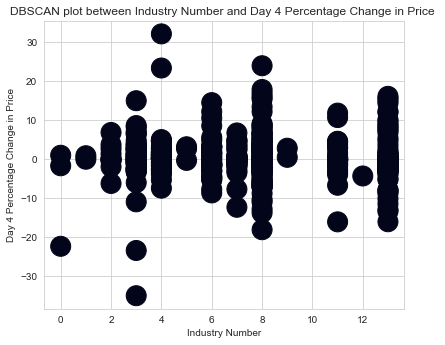

In [56]:
fig = plt.figure()

ax = fig.add_axes([.1,.1,1,1])

colors = model.labels_

y_kmeans = model.fit_predict(A) # this give the cluster number of the nearest centroid


# scatter plot the petal length (column 2), petal width (column 3)
ax.scatter(A.loc[:, 'sic_num'], A.loc[:,"day_4_change"], c=y_kmeans, s=400)

ax.set_xlabel('Industry Number')

ax.set_ylabel("Day 4 Percentage Change in Price")

plt.title("DBSCAN plot between Industry Number and Day 4 Percentage Change in Price ")

# show centroid centres as grey circle opacity 50%
#centers = model.labels
# plt.scatter(centers[:, 16], centers[:, 17], c='black', s=200, alpha=0.5)



Text(0.5, 1.0, 'DBSCAN plot between Industry Number and Day 3 Percentage Change in Price ')

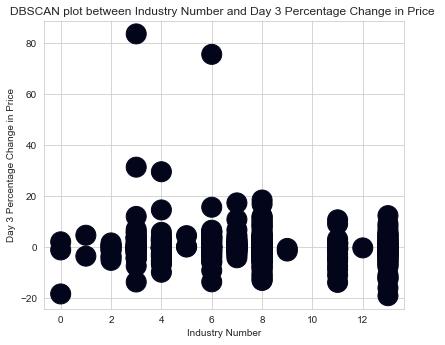

In [53]:
fig = plt.figure()

ax = fig.add_axes([.1,.1,1,1])

colors = model.labels_

y_kmeans = model.fit_predict(A) # this give the cluster number of the nearest centroid


# scatter plot the petal length (column 2), petal width (column 3)
ax.scatter(A.loc[:, 'sic_num'], A.loc[:,"day_3_change"], c=y_kmeans, s=400)

ax.set_xlabel('Industry Number')

ax.set_ylabel("Day 3 Percentage Change in Price")

plt.title("DBSCAN plot between Industry Number and Day 3 Percentage Change in Price ")


Text(0.5, 1.0, 'DBSCAN plot between Industry Number and Day 2 Percentage Change in Price ')

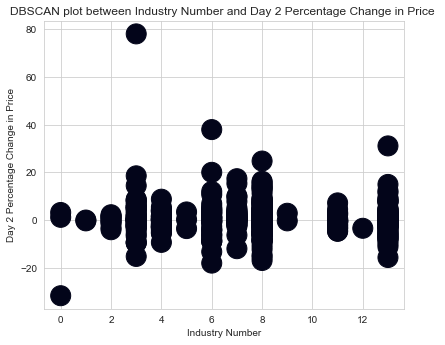

In [54]:
fig = plt.figure()

ax = fig.add_axes([.1,.1,1,1])

colors = model.labels_

y_kmeans = model.fit_predict(A) # this give the cluster number of the nearest centroid


# scatter plot the petal length (column 2), petal width (column 3)
ax.scatter(A.loc[:, 'sic_num'], A.loc[:,"day_2_change"], c=y_kmeans, s=400)

ax.set_xlabel('Industry Number')

ax.set_ylabel("Day 2 Percentage Change in Price")

plt.title("DBSCAN plot between Industry Number and Day 2 Percentage Change in Price ")


Text(0.5, 1.0, 'DBSCAN plot between Industry Number and Day 1 Percentage Change in Price ')

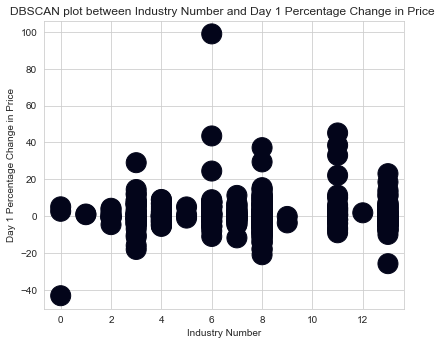

In [57]:
fig = plt.figure()

ax = fig.add_axes([.1,.1,1,1])

colors = model.labels_

y_kmeans = model.fit_predict(A) # this give the cluster number of the nearest centroid


# scatter plot the petal length (column 2), petal width (column 3)
ax.scatter(A.loc[:, 'sic_num'], A.loc[:,"day_1_change"], c=y_kmeans, s=400)

ax.set_xlabel('Industry Number')

ax.set_ylabel("Day 1 Percentage Change in Price")

plt.title("DBSCAN plot between Industry Number and Day 1 Percentage Change in Price ")

Text(0.5, 1.0, 'DBSCAN plot between Initial Price Offering and Day 2 Percentage Change in Price ')

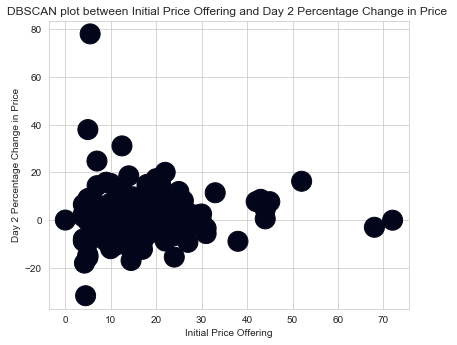

In [58]:
fig = plt.figure()

ax = fig.add_axes([.1,.1,1,1])

colors = model.labels_

y_kmeans = model.fit_predict(A) # this give the cluster number of the nearest centroid


# scatter plot the petal length (column 2), petal width (column 3)
ax.scatter(A.loc[:, 'share_price'], A.loc[:,"day_2_change"], c=y_kmeans, s=400)

ax.set_xlabel('Initial Price Offering')

ax.set_ylabel("Day 2 Percentage Change in Price")

plt.title("DBSCAN plot between Initial Price Offering and Day 2 Percentage Change in Price ")

Text(0.5, 1.0, 'DBSCAN plot between Initial Price Offering and Day 1 Percentage Change in Price ')

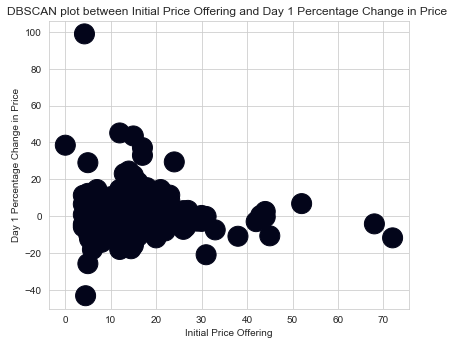

In [59]:
fig = plt.figure()

ax = fig.add_axes([.1,.1,1,1])

colors = model.labels_

y_kmeans = model.fit_predict(A) # this give the cluster number of the nearest centroid


# scatter plot the petal length (column 2), petal width (column 3)
ax.scatter(A.loc[:, 'share_price'], A.loc[:,"day_1_change"], c=y_kmeans, s=400)

ax.set_xlabel('Initial Price Offering')

ax.set_ylabel("Day 1 Percentage Change in Price")

plt.title("DBSCAN plot between Initial Price Offering and Day 1 Percentage Change in Price ")

Text(0.5, 1.0, 'DBSCAN plot between Initial Price Offering and Day 3 Percentage Change in Price ')

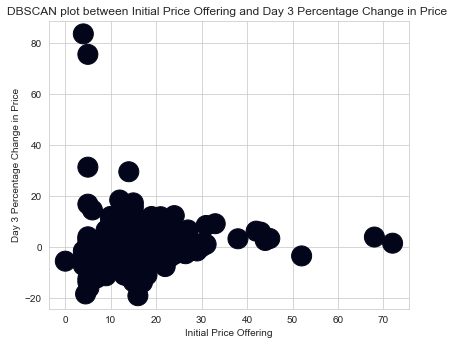

In [60]:
fig = plt.figure()

ax = fig.add_axes([.1,.1,1,1])

colors = model.labels_

y_kmeans = model.fit_predict(A) # this give the cluster number of the nearest centroid


# scatter plot the petal length (column 2), petal width (column 3)
ax.scatter(A.loc[:, 'share_price'], A.loc[:,"day_3_change"], c=y_kmeans, s=400)

ax.set_xlabel('Initial Price Offering')

ax.set_ylabel("Day 3 Percentage Change in Price")

plt.title("DBSCAN plot between Initial Price Offering and Day 3 Percentage Change in Price ")

Text(0.5, 1.0, 'DBSCAN plot between Initial Price Offering and Day 4 Percentage Change in Price ')

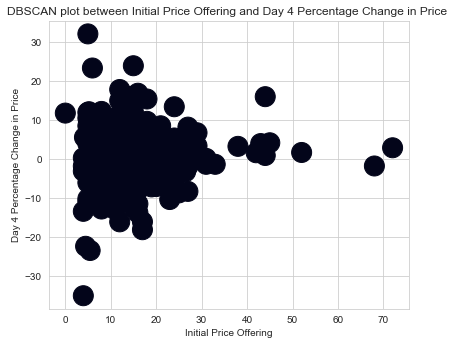

In [61]:
fig = plt.figure()

ax = fig.add_axes([.1,.1,1,1])

colors = model.labels_

y_kmeans = model.fit_predict(A) # this give the cluster number of the nearest centroid


# scatter plot the petal length (column 2), petal width (column 3)
ax.scatter(A.loc[:, 'share_price'], A.loc[:,"day_4_change"], c=y_kmeans, s=400)

ax.set_xlabel('Initial Price Offering')

ax.set_ylabel("Day 4 Percentage Change in Price")

plt.title("DBSCAN plot between Initial Price Offering and Day 4 Percentage Change in Price ")

Text(0.5, 0.92, 'DBSCAN plot of  Industry Number, Revenue Growth, and Day 4 Percentage Change in Price')

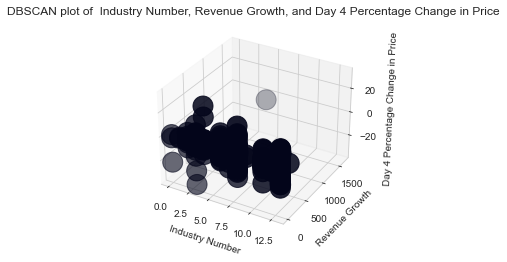

In [68]:
fig = plt.figure()

ax = plt.axes(projection="3d")

colors = model.labels_

y_kmeans = model.fit_predict(A) # this give the cluster number of the nearest centroid


# scatter plot the petal length (column 2), petal width (column 3)
ax.scatter3D(A.loc[:, 'sic_num'],A.loc[:, 'revenue_growth'] ,A.loc[:,"day_4_change"], c=colors, s=400)

ax.set_xlabel('Industry Number')

ax.set_ylabel('Revenue Growth')

ax.set_zlabel("Day 4 Percentage Change in Price")

plt.title("DBSCAN plot of  Industry Number, Revenue Growth, and Day 4 Percentage Change in Price")

Text(0.5, 0.92, 'DBSCAN plot of  Industry Number, Revenue Growth, and Day 1 Percentage Change in Price')

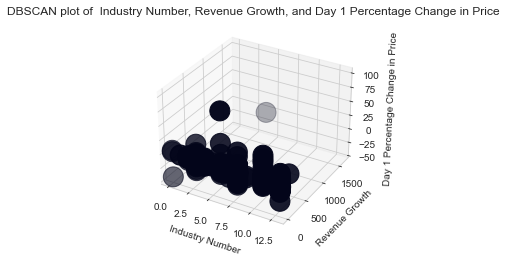

In [69]:
fig = plt.figure()

ax = plt.axes(projection="3d")

colors = model.labels_

y_kmeans = model.fit_predict(A) # this give the cluster number of the nearest centroid


# scatter plot the petal length (column 2), petal width (column 3)
ax.scatter3D(A.loc[:, 'sic_num'],A.loc[:, 'revenue_growth'] ,A.loc[:,"day_1_change"], c=colors, s=400)

ax.set_xlabel('Industry Number')

ax.set_ylabel('Revenue Growth')

ax.set_zlabel("Day 1 Percentage Change in Price")

plt.title("DBSCAN plot of  Industry Number, Revenue Growth, and Day 1 Percentage Change in Price")

Text(0.5, 0.92, 'DBSCAN plot of  Industry Number, Revenue Growth, and Day 2 Percentage Change in Price')

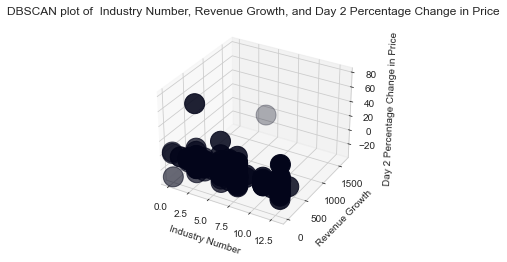

In [70]:
fig = plt.figure()

ax = plt.axes(projection="3d")

colors = model.labels_

y_kmeans = model.fit_predict(A) # this give the cluster number of the nearest centroid


# scatter plot the petal length (column 2), petal width (column 3)
ax.scatter3D(A.loc[:, 'sic_num'],A.loc[:, 'revenue_growth'] ,A.loc[:,"day_2_change"], c=colors, s=400)

ax.set_xlabel('Industry Number')

ax.set_ylabel('Revenue Growth')

ax.set_zlabel("Day 2 Percentage Change in Price")

plt.title("DBSCAN plot of  Industry Number, Revenue Growth, and Day 2 Percentage Change in Price")

Text(0.5, 0.92, 'DBSCAN plot of  Industry Number, Revenue Growth, and Day 3 Percentage Change in Price')

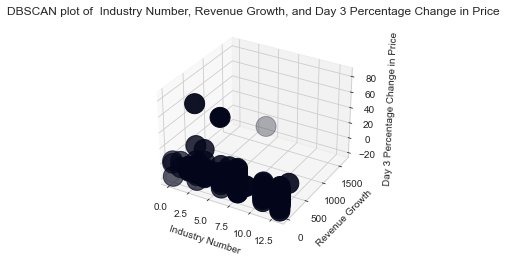

In [71]:
fig = plt.figure()

ax = plt.axes(projection="3d")

colors = model.labels_

y_kmeans = model.fit_predict(A) # this give the cluster number of the nearest centroid


# scatter plot the petal length (column 2), petal width (column 3)
ax.scatter3D(A.loc[:, 'sic_num'],A.loc[:, 'revenue_growth'] ,A.loc[:,"day_3_change"], c=colors, s=400)

ax.set_xlabel('Industry Number')

ax.set_ylabel('Revenue Growth')

ax.set_zlabel("Day 3 Percentage Change in Price")

plt.title("DBSCAN plot of  Industry Number, Revenue Growth, and Day 3 Percentage Change in Price")

In [74]:
data_1 = pd.read_csv("./data_collection_part1\part_1_data\companies_years_2009_2020_p1_v1_total.csv",  index_col=0)
data_1



,company_name,ticker,exchange,share_price,shares_offered,dollar_value_of_shares,date_of_priced,href
0,Mead Johnson Nutrition CO,MJN,New York Stock Exchange,24.00,"30,000,000","$720,000,000",2009-02-11,/market-activity/ipos/overview?dealId=794428-5...
1,"NIVS IntelliMedia Technology Group, Inc.",NIV,New York Stock Exchange,3.50,"550,000","$1,925,000",2009-03-13,/market-activity/ipos/overview?dealId=749089-5...
2,Changyou.com Ltd,CYOU,Nasdaq National Market,16.00,"7,500,000","$120,000,000",2009-04-02,/market-activity/ipos/overview?dealId=800114-6...
3,Zovio Inc,ZVO,New York Stock Exchange,10.50,"13,500,000","$141,750,000",2009-04-15,/market-activity/ipos/overview?dealId=651558-5...
4,ROSETTA STONE INC,RST,New York Stock Exchange,18.00,"6,250,000","$112,500,000",2009-04-16,/market-activity/ipos/overview?dealId=697501-5...
...,...,...,...,...,...,...,...,...
1553,Ozon Holdings PLC,OZON,NASDAQ Global Select,30.00,"33,000,000","$990,000,000",2020-11-24,/market-activity/ipos/overview?dealId=1133299-...
1554,Spartan Acquisition Corp. II,SPRQU,NYSE,10.00,"30,000,000","$300,000,000",2020-11-25,/market-activity/ipos/overview?dealId=1130836-...
1555,Forest Road Acquisition Corp.,FRX'U,NYSE,10.00,"26,100,000","$261,000,000",2020-11-25,/market-activity/ipos/overview?dealId=1130644-...
1556,"LIXTE BIOTECHNOLOGY HOLDINGS, INC.",LIXT,NASDAQ Capital,4.75,"1,200,000","$5,700,000",2020-11-25,/market-activity/ipos/overview?dealId=681720-9...


In [75]:
data_2 = pd.read_csv("./data_collection_part1\part_2_data\companies_years_2009_2020_p2_v1_total.csv",  index_col=0)
data_2

,company_name,ticker,exchange,share_price,shares_offered,dollar_value_of_shares,date_of_priced,href,employees,shares_outstanding,stock_valuation,company_address,phone
0,Mead Johnson Nutrition CO,MJN,New York Stock Exchange,24.0,"30,000,000","$720,000,000",2009-02-11,/market-activity/ipos/overview?dealId=794428-5...,5500,"72,344,571",1.736270e+09,225 NORTH CANAL STREET 25TH FLOOR CHICAGO IL ...,3124665800
1,"NIVS IntelliMedia Technology Group, Inc.",NIV,New York Stock Exchange,3.5,"550,000","$1,925,000",2009-03-13,/market-activity/ipos/overview?dealId=749089-5...,1650,"39,646,207",1.387617e+08,"NIVS INDUSTRY PARK, SHUIKOU, HUIZHOU, GUANGDO...",86-752-2323616
2,Changyou.com Ltd,CYOU,Nasdaq National Market,16.0,"7,500,000","$120,000,000",2009-04-02,/market-activity/ipos/overview?dealId=800114-6...,628,"7,500,000",1.200000e+08,"EAST TOWER, JING YAN BUILDING NO. 29 SHIJINGSH...",86 10 62 72 7777
3,Zovio Inc,ZVO,New York Stock Exchange,10.5,"13,500,000","$141,750,000",2009-04-15,/market-activity/ipos/overview?dealId=651558-5...,2971,"53,139,723",5.579671e+08,1811 E NORTHROP BLVD CHANDLER AZ 85286,858-668-2586
4,ROSETTA STONE INC,RST,New York Stock Exchange,18.0,"6,250,000","$112,500,000",2009-04-16,/market-activity/ipos/overview?dealId=697501-5...,1218,"20,314,531",3.656616e+08,1621 NORTH KENT STREET SUITE 1200 ARLINGTON V...,703-387-5800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,"MARAVAI LIFESCIENCES HOLDINGS, INC.",MRVI,NASDAQ Global Select,27.0,"60,000,000","$1,620,000,000",2020-11-20,/market-activity/ipos/overview?dealId=1132902-...,390,"88,965,664",2.402073e+09,10770 WATERIDGE CIRCLE SUITE 200 SAN DIEGO C...,(858) 546-0004
1080,Sotera Health Co,SHC,NASDAQ Global Select,23.0,"46,600,000","$1,071,800,000",2020-11-20,/market-activity/ipos/overview?dealId=1132288-...,2900,"277,431,755",6.380930e+09,"9100 SOUTH HILLS BLVD, SUITE 300 BROADVIEW H...",440-262-1410
1081,Vision Marine Technologies Inc.,VMAR,NASDAQ Capital,10.0,"2,400,000","$24,000,000",2020-11-24,/market-activity/ipos/overview?dealId=1121905-...,14,"7,577,677",7.577677e+07,730 BOULEVARD DU CURE-BOIVIN BOISBRAIND J7G...,3476150188
1082,Alset EHome International Inc.,HFEN,NASDAQ Capital,7.0,"2,160,000","$15,120,000",2020-11-24,/market-activity/ipos/overview?dealId=1104496-...,20,"8,560,000",5.992000e+07,"HAMPDEN SQUARE,4800 MONTGOMERY LANE SUITE 210 ...",3019713955


In [76]:
data_3 = pd.read_csv("./data_collection_part1\part_3_data\companies_years_2009_2020_p3_v1_total.csv",  index_col=0)
data_3

,company_name,ticker,exchange,share_price,shares_offered,dollar_value_of_shares,date_of_priced,href,employees,shares_outstanding,...,company_address,phone,sicdescription,ebit,grossprofit,netincome,totalrevenue,costofrevenue,totalassets,revenue_growth
0,Zovio Inc,ZVO,New York Stock Exchange,10.5,"13,500,000","$141,750,000",2009-04-15,/market-activity/ipos/overview?dealId=651558-5...,2971,"53,139,723",...,1811 E NORTHROP BLVD CHANDLER AZ 85286,858-668-2586,Services-Educational Services,33420000.0,155468000.0,26431000.0,2.182900e+08,6.282200e+07,1.292460e+08,1.546874
1,"Recon Technology, Ltd",RCON,Nasdaq SmallCap Market,6.0,"1,700,000","$10,200,000",2009-07-30,/market-activity/ipos/overview?dealId=785247-5...,96,"3,951,811",...,"ROOM 601, 1 SHUI'AN SOUTH STREET CHAOYANG DIST...",86 10 8494-5799,"Oil and Gas Field Services, Not Elsewhere Clas...",2436607.0,3789779.0,1691949.0,9.592261e+06,5.802482e+06,8.933083e+06,0.262541
2,CUMBERLAND PHARMACEUTICALS INC,CPIX,Nasdaq National Market,17.0,"5,000,000","$85,000,000",2009-08-11,/market-activity/ipos/overview?dealId=109945-5...,59,"17,091,191",...,"2525 WEST END AVENUE SUITE 950 NASHVILLE, TN ...",615-255-0068,Pharmaceutical Preparations,7282221.0,32029488.0,4766249.0,3.507516e+07,3.045672e+06,3.111919e+07,0.249846
3,SELECT MEDICAL HOLDINGS CORP,SEM,New York Stock Exchange,10.0,"30,000,000","$300,000,000",2009-09-25,/market-activity/ipos/overview?dealId=667059-5...,21700,"156,092,873",...,C/O SELECT MEDICAL CORP 4714 GETTYSBURG RD ME...,717-972-1100,Services-Hospitals,196408000.0,361521000.0,22441000.0,2.153362e+09,1.791841e+09,2.562425e+09,0.081186
4,"Echo Global Logistics, Inc.",ECHO,Nasdaq National Market,14.0,"5,700,000","$79,800,000",2009-10-02,/market-activity/ipos/overview?dealId=777083-5...,553,"21,493,655",...,600 WEST CHICAGO AVENUE SUITE 725 CHICAGO IL ...,1-800-354-7993,Arrangement of Transportation of Freight and C...,4945195.0,43090276.0,2875556.0,2.028076e+08,1.597174e+08,4.590902e+07,1.124508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,Yatsen Holding Ltd,YSG,NYSE,10.5,"58,750,000","$616,875,000",2020-11-19,/market-activity/ipos/overview?dealId=1133021-...,3355,"58,750,000",...,"32-35, 38/F, POLY MIDTOWN PLAZA NO.23 EAST XUA...",86 20 38373543,"Perfumes, Cosmetics and Other Toilet Preparations",20638000.0,276736000.0,10055000.0,4.351560e+08,1.584200e+08,2.886020e+08,3.702610
446,"MARAVAI LIFESCIENCES HOLDINGS, INC.",MRVI,NASDAQ Global Select,27.0,"60,000,000","$1,620,000,000",2020-11-20,/market-activity/ipos/overview?dealId=1132902-...,390,"88,965,664",...,10770 WATERIDGE CIRCLE SUITE 200 SAN DIEGO C...,(858) 546-0004,Pharmaceutical Preparations,23988000.0,76291000.0,-4470000.0,1.431400e+08,6.684900e+07,5.777960e+08,0.155912
447,Sotera Health Co,SHC,NASDAQ Global Select,23.0,"46,600,000","$1,071,800,000",2020-11-20,/market-activity/ipos/overview?dealId=1132288-...,2900,"277,431,755",...,"9100 SOUTH HILLS BLVD, SUITE 300 BROADVIEW H...",440-262-1410,Services-Miscellaneous Health and Allied Servi...,183597000.0,395431000.0,-20850000.0,7.783270e+08,3.828960e+08,2.580674e+09,0.043125
448,Vision Marine Technologies Inc.,VMAR,NASDAQ Capital,10.0,"2,400,000","$24,000,000",2020-11-24,/market-activity/ipos/overview?dealId=1121905-...,14,"7,577,677",...,730 BOULEVARD DU CURE-BOIVIN BOISBRAIND J7G...,3476150188,Ship And Boat Building And Repairing,333700.0,1285364.0,233066.0,2.869377e+06,1.584013e+06,1.914562e+06,1.256569


In [77]:
data_2 = pd.read_csv("./data_collection_part1\part_4_data\companies_years_2009_2020_p4_v1_total.csv",  index_col=0)
data_2

,company_name,ticker,exchange,share_price,shares_offered,dollar_value_of_shares,date_of_priced,href,employees,shares_outstanding,...,netincome,totalrevenue,costofrevenue,totalassets,revenue_growth,1,2,3,4,5
0,Zovio Inc,ZVO,New York Stock Exchange,10.5,"13,500,000","$141,750,000",2009-04-15,/market-activity/ipos/overview?dealId=651558-5...,2971,"53,139,723",...,26431000.0,2.182900e+08,6.282200e+07,1.292460e+08,1.546874,$11.1000,$12.0500,$12.0100,$11.6500,$11.0000
1,"Recon Technology, Ltd",RCON,Nasdaq SmallCap Market,6.0,"1,700,000","$10,200,000",2009-07-30,/market-activity/ipos/overview?dealId=785247-5...,96,"3,951,811",...,1691949.0,9.592261e+06,5.802482e+06,8.933083e+06,0.262541,$27.8500,$29.7500,$32.3500,$37.0500,$45.7000
2,CUMBERLAND PHARMACEUTICALS INC,CPIX,Nasdaq National Market,17.0,"5,000,000","$85,000,000",2009-08-11,/market-activity/ipos/overview?dealId=109945-5...,59,"17,091,191",...,4766249.0,3.507516e+07,3.045672e+06,3.111919e+07,0.249846,$16.8300,$17.0000,$17.0450,$17.0100,$16.8000
3,SELECT MEDICAL HOLDINGS CORP,SEM,New York Stock Exchange,10.0,"30,000,000","$300,000,000",2009-09-25,/market-activity/ipos/overview?dealId=667059-5...,21700,"156,092,873",...,22441000.0,2.153362e+09,1.791841e+09,2.562425e+09,0.081186,$10.09,$10.45,$10.09,$10.07,$10.00
4,"Echo Global Logistics, Inc.",ECHO,Nasdaq National Market,14.0,"5,700,000","$79,800,000",2009-10-02,/market-activity/ipos/overview?dealId=777083-5...,553,"21,493,655",...,2875556.0,2.028076e+08,1.597174e+08,4.590902e+07,1.124508,$14.06,$14.00,$14.00,$13.51,$12.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,Yatsen Holding Ltd,YSG,NYSE,10.5,"58,750,000","$616,875,000",2020-11-19,/market-activity/ipos/overview?dealId=1133021-...,3355,"58,750,000",...,10055000.0,4.351560e+08,1.584200e+08,2.886020e+08,3.702610,$18.40,$20.03,$18.24,$17.15,$16.86
446,"MARAVAI LIFESCIENCES HOLDINGS, INC.",MRVI,NASDAQ Global Select,27.0,"60,000,000","$1,620,000,000",2020-11-20,/market-activity/ipos/overview?dealId=1132902-...,390,"88,965,664",...,-4470000.0,1.431400e+08,6.684900e+07,5.777960e+08,0.155912,$29.85,$29.00,$26.29,$26.96,$29.16
447,Sotera Health Co,SHC,NASDAQ Global Select,23.0,"46,600,000","$1,071,800,000",2020-11-20,/market-activity/ipos/overview?dealId=1132288-...,2900,"277,431,755",...,-20850000.0,7.783270e+08,3.828960e+08,2.580674e+09,0.043125,$25.10,$27.95,$27.00,$26.76,$27.97
448,Vision Marine Technologies Inc.,VMAR,NASDAQ Capital,10.0,"2,400,000","$24,000,000",2020-11-24,/market-activity/ipos/overview?dealId=1121905-...,14,"7,577,677",...,233066.0,2.869377e+06,1.584013e+06,1.914562e+06,1.256569,$14.44,$14.21,$14.12,$13.15,$12.79
